In [1]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

ResNet50

In [2]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Check Image Corruption

In [39]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Corrupted image: images\.DS_Store - cannot identify image file 'images\\.DS_Store'
Total corrupted images: 1


In [40]:
def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        
        # Quality enhancement
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness
        
        # Noise reduction
        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Consistency
        img = img.resize(size, Image.LANCZOS)
        
        return img
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error processing image {image_path}: {e}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [4]:
train_dir = 'processed_images'
# train_dir = 'images_train_test_val/train'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    # rotation_range=20,  # Randomly rotate images
    # width_shift_range=0.2,  # Randomly shift images horizontally
    # height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 25/165 ━━━━━━━━━━━━━━━━━━━━ 22:53 10s/step - accuracy: 0.2681 - loss: 2.4958

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

NameError: name 'history' is not defined

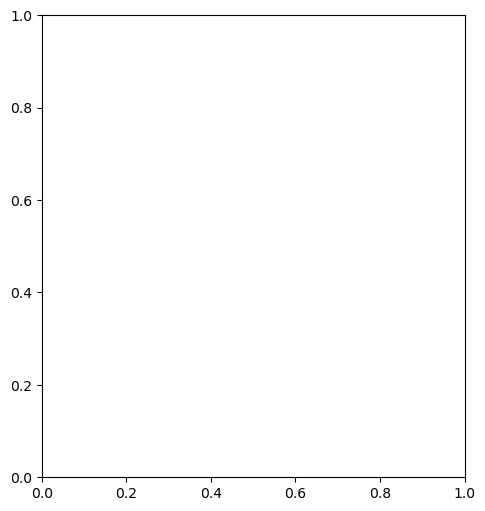

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


ResNet50 with GridSearch tuning